# **Part 5 - Modelling & Evaluation (Predict SalePrice)**

## Objectives

* Fit and evaluate a Regression Model to predict sale price for our data

## Inputs

* X_train (Features)
* y_train (Target)
* X_test (Features)
* y_test (Target)
* Selected transformers for data cleaning and feature engineering (details in respective notebooks)

## Outputs

* Feature Engineering Pipeline
* Modelling & Evalutation Pipeline
* Plots for feature importance

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 


---

# Change working directory

* As the notebooks are stored in a subfolder, when running the notebook in the editor, the working directory will need to be adjusted.

The working directory will be changed from its current folder to its parent folder
* access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Project5-PredictiveAnalytics-HeritageHousing/jupyter_notebooks'

The parent of the current directory needs to be made the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


* Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Project5-PredictiveAnalytics-HeritageHousing'

---

# Load Data

In [4]:
import numpy as np
import pandas as pd 
X_train = pd.read_csv('./outputs/datasets/clean/X_train.csv')
y_train = pd.read_csv('./outputs/datasets/clean/y_train.csv')

In [5]:
print(f'Features Train Set: {X_train.shape}')
print(f'Target Train Set: {y_train.shape}')


Features Train Set: (1168, 23)
Target Train Set: (1168, 1)


### Features - Train Set

In [6]:
X_train.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd
0,1222,698.0,4.0,No,0,Unf,570,0.0,487,RFn,...,10192,102.0,143.0,98,6,7,570,0.0,1968,1992
1,1165,0.0,4.0,No,0,Unf,1141,0.0,420,Fin,...,12090,93.0,650.0,123,5,8,1141,144.0,1998,1998
2,698,430.0,2.0,No,0,Unf,698,0.0,528,RFn,...,7500,60.0,0.0,0,4,4,698,0.0,1920,1950
3,1844,0.0,2.0,No,976,GLQ,868,0.0,620,Fin,...,10994,88.0,366.0,44,5,8,1844,0.0,2005,2006
4,1419,0.0,2.0,Av,945,Unf,474,0.0,567,RFn,...,8089,60.0,0.0,0,6,8,1419,0.0,2007,2007


### Target - Train Set

In [7]:
y_train.head()

,SalePrice
0,170000
1,258000
2,68400
3,257000
4,392000


---

# ML Pipeline

### Initial Pipeline Creation

First we will import the neccesary packages, including the feature engineering transformers, scalers, and ML algorithms. We do not need to include the data cleaning steps within our pipeline, as our data has already been cleaned and split into our test and train sets. However, it is useful to note that including those cleaning steps within the pipeline, along with the feature engineering steps, and inputing the raw data, before then splitting into our training and test sets is also a valid approach. 

In [8]:
from sklearn.pipeline import Pipeline

# Feature Engineering 
from feature_engine.encoding import OrdinalEncoder
from feature_engine import transformation as vt 
from feature_engine.outliers import Winsorizer, OutlierTrimmer
from feature_engine.selection import SmartCorrelatedSelection

# Feature Preprocessing (Scaling & Selection)
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

# Machine Learning Algorithms
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Next we create our pipeline using the transformers and parameters decided up during our feature engineering notebook, we wont go into detail again here, so please refer back to that notebook for more information. 

In [9]:
def PipelineReg(model):
    pipeline = Pipeline([
        ('Ordinal Categorical Encoder', OrdinalEncoder(encoding_method='ordered', variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),
        ('Log "e" Transformer', vt.LogTransformer(variables=['GrLivArea', 'LotArea'])),
        ('Power Transformer', vt.PowerTransformer(variables=['BsmtFinSF1', 'BsmtUnfSF', 'MasVnrArea', 'OpenPorchSF'])),
        ('Box Cox Transformer', vt.BoxCoxTransformer(variables=['1stFlrSF'])),
        ('Yeo Johnson Transformer', vt.YeoJohnsonTransformer(variables=['EnclosedPorch', 'LotFrontage', 'TotalBsmtSF', 'WoodDeckSF'])),
        ('Winsorizer', Winsorizer(capping_method='gaussian', tail='right', variables=['LotFrontage', 'TotalBsmtSF'])),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.8, selection_method="variance")),
        # The Scaler standardizes features by removing the mean and scaling unit to unit variance 
        ('Feature Scaling', StandardScaler()),
        # Feature selection uses the meta-transformer to select the best features to use within the model based on their importance weights.
        ('Feature Selection', SelectFromModel(model)),
        ('Model', model)
    ])

    return pipeline

### Hyperparameter Optimization

Next we will explore hyperparameter optimization, selecting the best algorithm and its best hyperparameters to use within our pipeline.

In [10]:
from sklearn.model_selection import GridSearchCV

We will again implement some custom code from CodeInstitute to create a class to search for the optimal Hyperparameters, using the SciKit Learn package GridSearchCV we have just imported.

In [11]:
class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searchs = {}

    def fit(self, features, target, cross_validation, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\n **Running GridSearchCV for {key}** \n")
            import warnings
            warnings.simplefilter(action='ignore', category=FutureWarning)
            model = PipelineReg(self.models[key])
            params = self.params[key]
            gridsearch = GridSearchCV(model, params, cv=cross_validation, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            gridsearch.fit(features, target)
            self.grid_searchs[key] = gridsearch
    
    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})
        
        rows = []
        for k in self.grid_searchs:
            params = self.grid_searchs[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searchs[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searchs[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))
            
            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append(row(k, s, p))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = [
            'estimator',
            'min_score',
            'mean_score',
            'max_score',
            'std_score'
            ]
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searchs

First we will perform a grid search with the default hyperparameters to find the most appropriate algorithm for our model.
* *Again, for reproducibility we will use the random state attribute*

In [12]:
quick_search_models = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=23),
    "RandomForestRegressor": RandomForestRegressor(random_state=23),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=23),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=23),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=23),
    "XGBRegressor": XGBRegressor(random_state=23),
}

quick_search_params = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

*To keep our notebook a little tidier we have made some minor changes to subvert the warnings that would be thrown but always remember its good practice to keep note of all warnings and handle accordingly*
* <code>FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.</code>
    * To fix this warning we change n_jobs from -1 to 1 
* <code>DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().</code>
    * To fix this warning we handle some slight data conversion, by using the numpy function <code>ravel()</code> on the values of our y_train, and convert to a pandas series as a numpy array is not an accepted input 

In [13]:
base_search = HyperparameterOptimizationSearch(models=quick_search_models, params=quick_search_params)
base_search.fit(features=X_train, target=pd.Series(y_train.values.ravel()), scoring='r2', n_jobs=1, cross_validation=5)


 **Running GridSearchCV for LinearRegression** 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

 **Running GridSearchCV for DecisionTreeRegressor** 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

 **Running GridSearchCV for RandomForestRegressor** 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

 **Running GridSearchCV for ExtraTreesRegressor** 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

 **Running GridSearchCV for AdaBoostRegressor** 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

 **Running GridSearchCV for GradientBoostingRegressor** 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

 **Running GridSearchCV for XGBRegressor** 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Now we can check the results

In [14]:
grid_search_summary, grid_search_pipelines = base_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.715738,0.801543,0.872317,0.064537
0,LinearRegression,0.728023,0.794907,0.84446,0.046269
2,RandomForestRegressor,0.725459,0.784715,0.828253,0.044948
5,GradientBoostingRegressor,0.695142,0.775957,0.85106,0.057544
4,AdaBoostRegressor,0.71867,0.758176,0.790711,0.026214
6,XGBRegressor,0.514374,0.652946,0.760647,0.080995
1,DecisionTreeRegressor,0.488662,0.628737,0.715119,0.081611


We will also import the a metrics function to use within GridSearchCV for use as our scoring strategy. With more time and resources an investigation could be led on the effect of different possible scoring strategies and the effect they will have on the grid search cross validation. For this study we will examine just a single other scoring strategy and see the effect it has on the algorithm selection. For this study as we are using an older version of SciKit Learn we will be limited in our selection of scoring methods.

* We will use the <code>median_absolute_error</code> (*it is the negative, as that is the accepted value by the function*) to calculate the regression loss as our scoring method and see the effect it has on our algorithm search.
* A possible example of a method to use in a future iteration of this study could be using <code>d2_pinball_score</code> that was introduced in <code>version: 1.1</code> which will generate a D<sup>2</sup> regession score. It is a form of skill score and a generalization of the R<sup>2</sup> score. It compures the fraction of deviance explained, where the square error is generalized and replaced by a deviance of choice.

In [15]:
from sklearn.metrics import mean_absolute_error

In [16]:
mae_search = HyperparameterOptimizationSearch(models=quick_search_models, params=quick_search_params)
mae_search.fit(features=X_train, target=pd.Series(y_train.values.ravel()), scoring='neg_median_absolute_error', n_jobs=1, cross_validation=5)


 **Running GridSearchCV for LinearRegression** 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

 **Running GridSearchCV for DecisionTreeRegressor** 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

 **Running GridSearchCV for RandomForestRegressor** 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

 **Running GridSearchCV for ExtraTreesRegressor** 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

 **Running GridSearchCV for AdaBoostRegressor** 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

 **Running GridSearchCV for GradientBoostingRegressor** 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

 **Running GridSearchCV for XGBRegressor** 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [17]:
mae_grid_search_summary, mae_grid_search_pipelines = mae_search.score_summary(sort_by='mean_score')
mae_grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,-14932.8575,-13316.3215,-11683.5,1353.508106
5,GradientBoostingRegressor,-16777.525815,-15566.451212,-14162.049392,885.972846
2,RandomForestRegressor,-20669.64,-16021.39081,-13588.808333,2615.06571
0,LinearRegression,-18657.307734,-16617.760839,-13791.714563,1664.442633
4,AdaBoostRegressor,-20675.0706,-17825.791788,-15012.980569,1939.434143
6,XGBRegressor,-25254.9375,-20118.457813,-18063.703125,2645.501802
1,DecisionTreeRegressor,-22500.0,-20796.1,-18200.0,1722.719025


As we can see when we check the results, while there is some variation between the algorithm search results, it confirms that <code>ExtraTreesRegressor</code> is the most appropriate algorthim to use that should yield the best results.

Now that we have our algorithm selected we will perform a search on the model for the best hyperparameter configuration. 

In [18]:
search_models = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=23)
}

search_params = {
    "ExtraTreesRegressor": {
        'Model__n_estimators': [100, 250, 350], # Default Value: 100
        'Model__criterion': ["mse"], # Default Value: mse (Mean Square Error) 
        # NOTE: project version of sci-kit learn only has two acceptable values for criterion, more recent releases have additional functions accepted
        'Model__max_depth':  [3, 5, 7], # Default Value: None
        'Model__min_samples_split': [2, 4, 6, 8, 10], # Default Value: 2
        'Model__min_samples_leaf': [1, 2, 3], # Default Value: 1
        'Model__max_features': ['auto', 'sqrt', 'log2'], # Default Value: 1.0
        'Model__max_leaf_nodes': [None, 5, 10, 15], # Default Value: None
        'Model__min_weight_fraction_leaf': [0.0, 0.25, 0.5] # Default Value: 0.0
    }
}

We have chosen 6 different hyperparameters to search with multiple acceptable values to give our search enough improve the variability of the search, we can adjust these values should it be deemed neccesary when we check the results of the cross validation search.

Our chosen hyperarameters are:
* <code>n_estimatiors</code>: The number of trees in the random decision forest. As this is an important consideration this is an obvious choice to optimize. 
* <code>criterion</code>: The function to measure the quality of a split when generating the random forest. We will leave criterion as MSE (Mean Square Error) as the computational time slows considerably for MAE. (Mean Absolute Error)
* <code>max_depth</code>: Defines the maximum depth of the tree. By configuring this hyperparameter we can reduce the chance of underfitting or overfitting the model
* <code>min_samples_split</code>: The minimum number of samples required to split a node. By configuring this hyperparameter we can prevent overfitting by creating branches with few samples
* <code>min_samples_leaf</code>: Similar to the previous hyperparameter, however this describes the minimum sample level at the leaf level, (base of the tree). Optimizing this parameter is important as increasing this value can lead to underfitting the model.
* <code>max_features</code>: The maximum number of features the model will consider when searching for the best split. We choose to optimize this hyperparameter as it can increase the model perfomance however we want to limit the risk of overfitting.
* <code>max_leaf_nodes</code>: Sets a limit on the splitting of nodes reducing growth of the tree. We choose to tune this hyperparameter as it can effectively help to reduce overfitting.
* <code>min_weight_fraction_leaf</code>: the minimum weighted fraction of the sum of total weights for the samples allowed on the node. By tuning this hyperparameter we can deal with any class imbalance by providing sample weights, and optimize the tree structure. 

In [19]:
estimator = ExtraTreesRegressor(random_state=23)
estimator.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

* *Warning: The search took ~207 minutes to run so avoid running again if possible, results will be posted below*

In [20]:
base_search = HyperparameterOptimizationSearch(models=search_models, params=search_params)
base_search.fit(features=X_train, target=pd.Series(y_train.values.ravel()), scoring='r2', n_jobs=1, cross_validation=5, verbose=1)


 **Running GridSearchCV for ExtraTreesRegressor** 

Fitting 5 folds for each of 4860 candidates, totalling 24300 fits


Now we have completed our cross validation search we can output the results.

In [21]:
optimization_grid_search_summary, optimization_grid_search_pipelines = base_search.score_summary(sort_by='mean_score')
optimization_grid_search_summary.head(10)

,estimator,min_score,mean_score,max_score,std_score,Model__criterion,Model__max_depth,Model__max_features,Model__max_leaf_nodes,Model__min_samples_leaf,Model__min_samples_split,Model__min_weight_fraction_leaf,Model__n_estimators
3303,ExtraTreesRegressor,0.746835,0.819898,0.863941,0.044228,mse,7,auto,None,2,6,0.0,100
3296,ExtraTreesRegressor,0.747454,0.818569,0.863464,0.04376,mse,7,auto,None,2,4,0.0,350
3287,ExtraTreesRegressor,0.747454,0.818569,0.863464,0.04376,mse,7,auto,None,2,2,0.0,350
3285,ExtraTreesRegressor,0.744961,0.818376,0.862536,0.043917,mse,7,auto,None,2,2,0.0,100
3294,ExtraTreesRegressor,0.744961,0.818376,0.862536,0.043917,mse,7,auto,None,2,4,0.0,100
3286,ExtraTreesRegressor,0.746266,0.818329,0.86282,0.043855,mse,7,auto,None,2,2,0.0,250
3295,ExtraTreesRegressor,0.746266,0.818329,0.86282,0.043855,mse,7,auto,None,2,4,0.0,250
3304,ExtraTreesRegressor,0.746914,0.818254,0.862696,0.044546,mse,7,auto,None,2,6,0.0,250
3339,ExtraTreesRegressor,0.743699,0.817661,0.86337,0.045395,mse,7,auto,None,3,4,0.0,100
3330,ExtraTreesRegressor,0.743699,0.817661,0.86337,0.045395,mse,7,auto,None,3,2,0.0,100


We can check the best hyperparameter configuration to use for our model. 

In [22]:
top_performing_params = optimization_grid_search_pipelines['ExtraTreesRegressor'].best_params_
top_performing_params

{'Model__criterion': 'mse',
 'Model__max_depth': 7,
 'Model__max_features': 'auto',
 'Model__max_leaf_nodes': None,
 'Model__min_samples_leaf': 2,
 'Model__min_samples_split': 6,
 'Model__min_weight_fraction_leaf': 0.0,
 'Model__n_estimators': 100}

We can also check for the top performing full regressor pipeline from our results.

In [23]:
top_performing_pipeline = optimization_grid_search_pipelines['ExtraTreesRegressor'].best_estimator_
top_performing_pipeline

Pipeline(steps=[('Ordinal Categorical Encoder',
                 OrdinalEncoder(variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('Log "e" Transformer',
                 LogTransformer(variables=['GrLivArea', 'LotArea'])),
                ('Power Transformer',
                 PowerTransformer(variables=['BsmtFinSF1', 'BsmtUnfSF',
                                             'MasVnrArea', 'OpenPorchSF'])),
                ('Box Cox Transformer',
                 BoxCoxTransformer(var...
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     'MasVnrArea',
                                                     'OpenPorchSF',
                                                     'OverallCond',
                                                     'OverallQual',
   

Now we can examine the feature importance within the model training and plot the results

There are 5 features with the highest importance to model training which are:
['OverallQual', 'KitchenQual', 'GrLivArea', 'TotalBsmtSF', 'GarageArea']


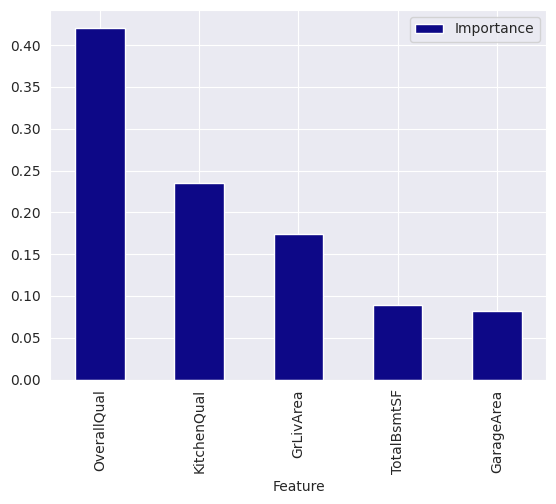

In [24]:
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_style('darkgrid')

pipeline_steps = 7
features_after_pipeline_steps = (Pipeline(top_performing_pipeline.steps[:pipeline_steps]).transform(X_train).columns)

most_important_features = features_after_pipeline_steps[top_performing_pipeline['Feature Selection'].get_support()].to_list()

feature_importance_results = pd.DataFrame(data={
    'Feature': features_after_pipeline_steps[top_performing_pipeline['Feature Selection'].get_support()],
    'Importance': top_performing_pipeline['Model'].feature_importances_
}).sort_values(by='Importance', ascending=False)


print(f"There are {len(most_important_features)} features with the highest importance to model training which are:"
      f"\n{feature_importance_results['Feature'].to_list()}")

feature_importance_results.plot(kind='bar', x='Feature', y='Importance', cmap='plasma')
plt.show()

---

## Regressor - Performance Evaluation

We will now evaluate how our pipeline performs on our train and test sets and examine its performance. Again we will use some custom code to display our results starting with importing another Sci-Kit Learn metric <code>R2 Score</code>. We will use this score to quantify our model's performance, as it is also how we set the goal for our predictions as part of the buisness case. Our model needs to reach a score of ***at least 0.75*** on both train and test sets to be considered a success.

In [25]:
from sklearn.metrics import r2_score


def regressor_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n \n")
    print("** TRAIN SET ** \n")
    regressor_evaluation(X_train, y_train, pipeline)
    print("\n** TEST SET** \n")
    regressor_evaluation(X_test, y_test, pipeline)


def regressor_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print(f"R2 Score: {r2_score(y, prediction).round(3)}")
    print(f"Mean Absolute Error: {mean_absolute_error(y, prediction).round(3)} \n")

We already have our train set loaded so now we can load our test set too and evaluate our model performance.

In [26]:
X_test = pd.read_csv('./outputs/datasets/clean/X_test.csv')
y_test = pd.read_csv('./outputs/datasets/clean/y_test.csv')
regressor_performance(X_train, y_train, X_test, y_test, top_performing_pipeline)

Model Evaluation 
 

** TRAIN SET ** 

R2 Score: 0.879
Mean Absolute Error: 18295.347 


** TEST SET** 

R2 Score: 0.838
Mean Absolute Error: 20663.128 



We will also generate some plots, to display our model performance visually.

In [27]:
def regressor_eval_plot(X_train, y_train, X_test, y_test, pipeline): #alpha_scatter=0.5
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
    sns.scatterplot(x=y_train['SalePrice'], y=pred_train, ax=axes[0]) #alpha=alpha_scatter
    sns.lineplot(x=y_train['SalePrice'], y=y_train['SalePrice'], color='purple', legend=True, ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test['SalePrice'], y=pred_test, ax=axes[1]) # alpha=alpha_scatter, 
    sns.lineplot(x=y_test['SalePrice'], y=y_test['SalePrice'], color='purple', legend=True, ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.suptitle("Model Performance: Predicted Values vs Actual")
    plt.show()

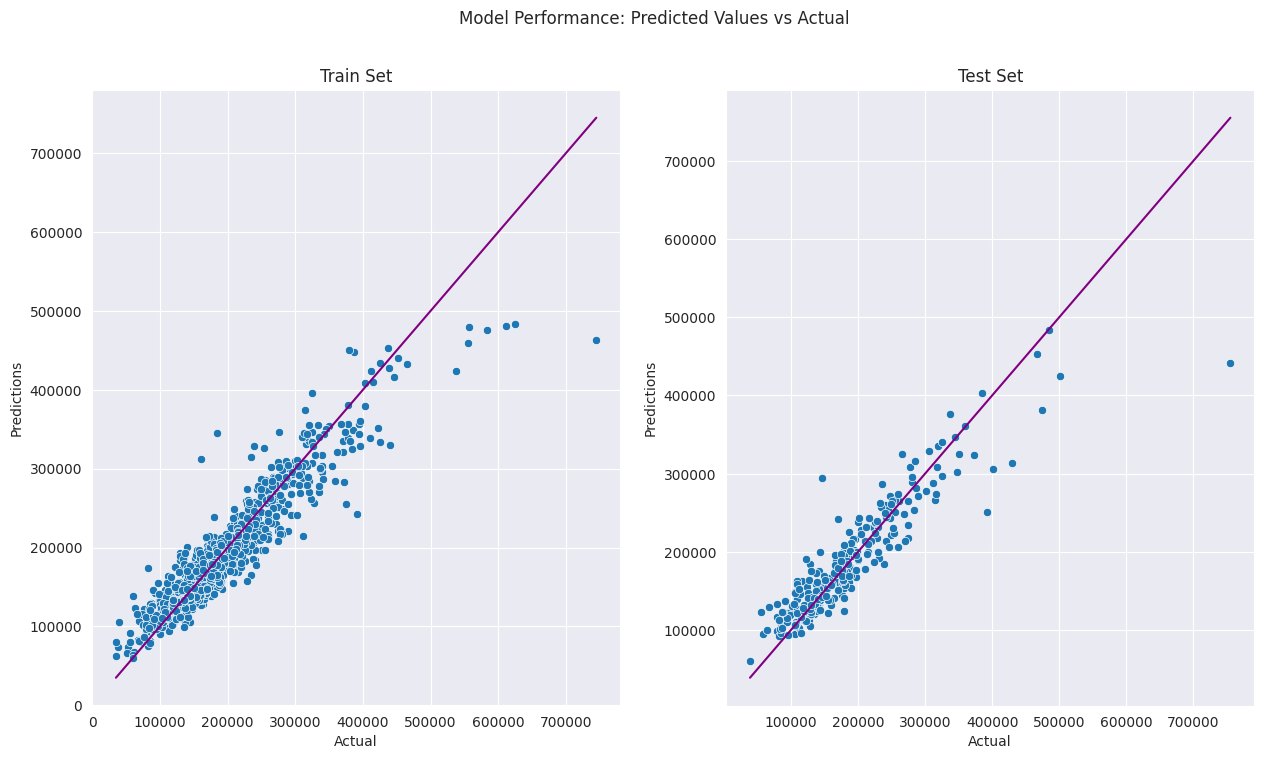

In [28]:
regressor_eval_plot(X_train, y_train, X_test, y_test, top_performing_pipeline)

### Regressor - Conclusions

With an R2 score of greater than 0.8 for both the train and test sets, our <code>ExtraTreesRegressor</code> performs successfully enough that it meets our business requirement. However in terms of completeness and ensuring the best possible performance we will also attempt to run a regressor pipeline with <code>Principle Componant Analysis</code> and see which pipeline performs better. 

---

# Principle Componant Analysis 

We will first prepare a new pipeline to explore potential values for the <code>n_components</code> parameter. For this we will again begin simply with the <code>LinearRegression</code> algorithm.

In [29]:
pipeline_optimizer = PipelineReg(model=LinearRegression())
pipeline_pca = Pipeline(pipeline_optimizer.steps[:8])
pca_data = pipeline_pca.fit_transform(X_train, y_train)

print(pca_data.shape, '\n', type(pca_data))

(1168, 21) 
 <class 'numpy.ndarray'>


Now we will apply PCA to our scaled data using the number of columns as our <code>n_components</code> parameter.

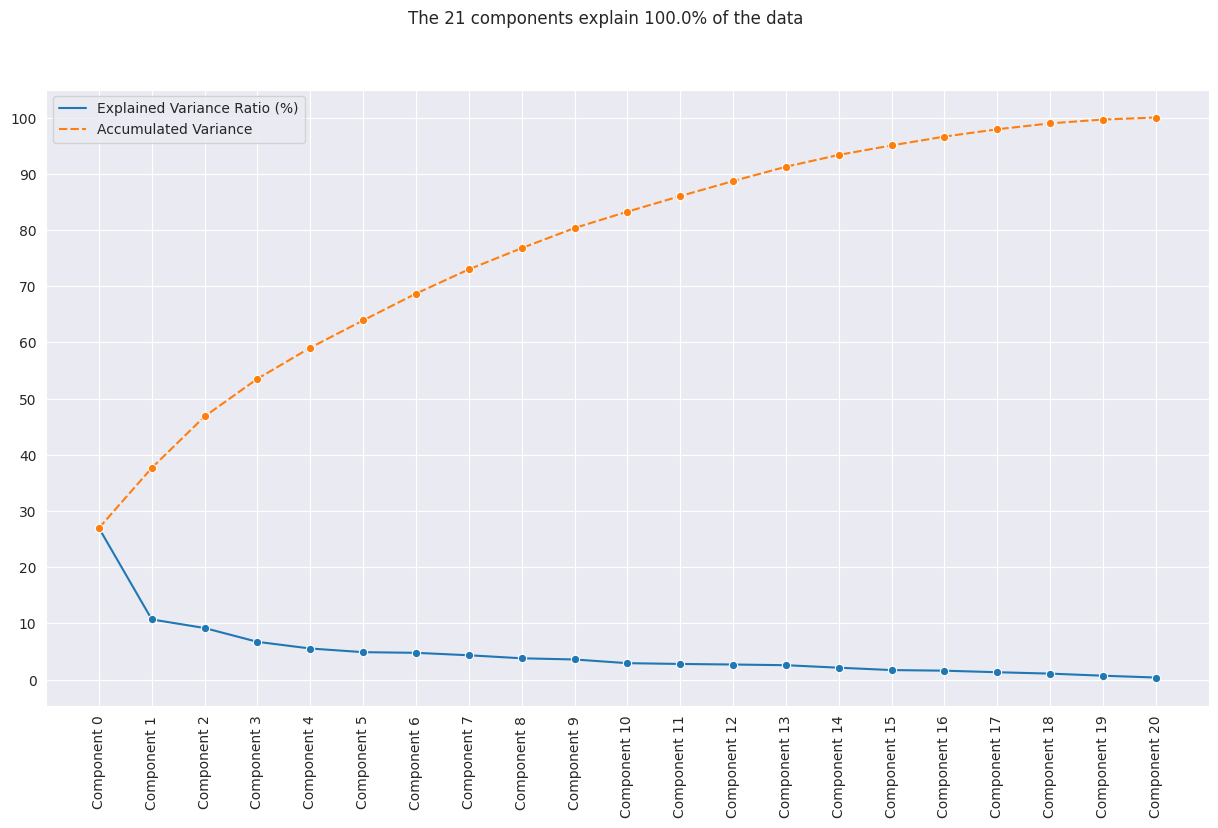

In [30]:
from sklearn.decomposition import PCA

n_components = 21

def pca_analysis(pca_data, n_components):
    pca = PCA(n_components=n_components).fit(pca_data)
    X_pca = pca.fit_transform(pca_data)

    components_list = ["Component " + str(number) for number in range(n_components)]
    variance_ratio = pd.DataFrame(
        data = np.round(100 * pca.explained_variance_ratio_, 3),
        index = components_list,
        columns = ['Explained Variance Ratio (%)']
    )

    variance_ratio['Accumulated Variance'] = variance_ratio['Explained Variance Ratio (%)'].cumsum()

    data_percentage_explained = variance_ratio['Explained Variance Ratio (%)'].sum()

    plt.figure(figsize=(15,8))
    plt.suptitle(f"The {n_components} components explain {round(data_percentage_explained, 2)}% of the data \n")
    sns.lineplot(data=variance_ratio, marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()

pca_analysis(pca_data, n_components)

Looking at this graph we can still cover 80% of the variation within the data by only using 10 components so let us reset the <code>n_components</code> value and see how that affects the graph.

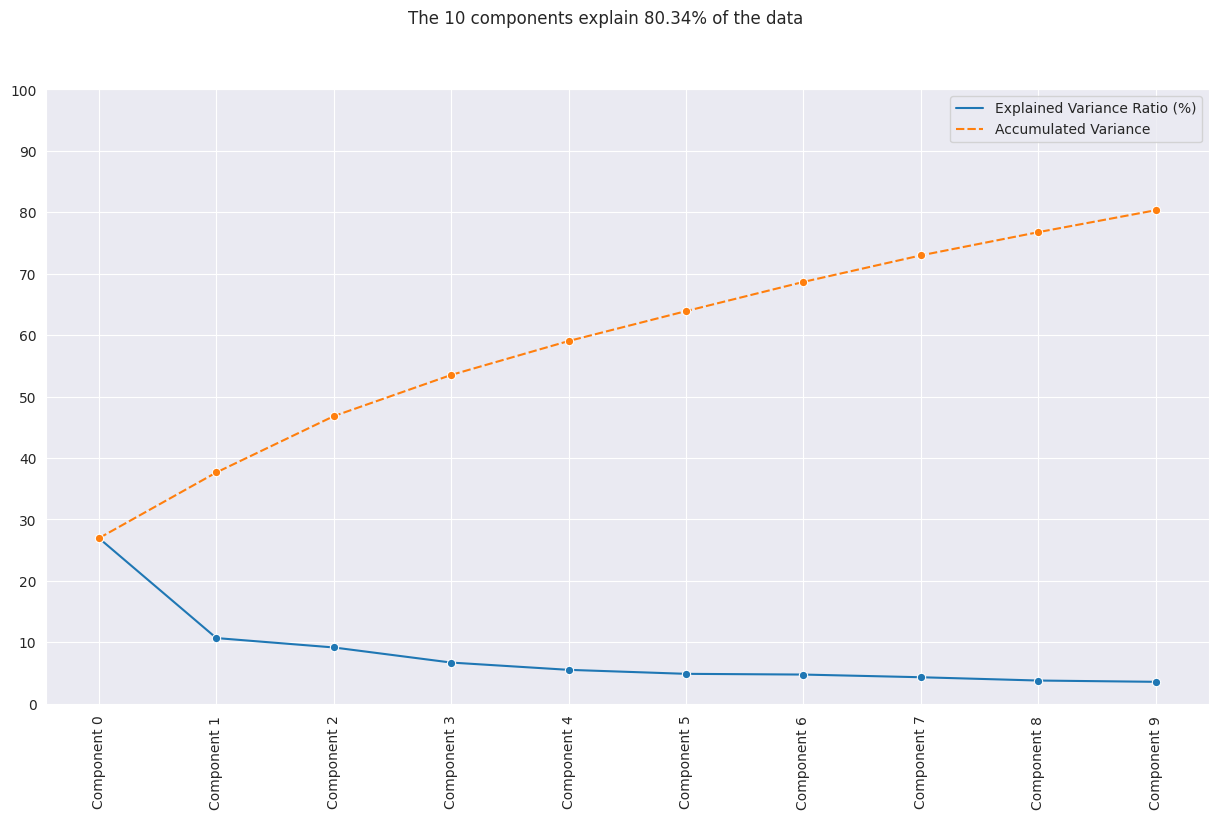

In [31]:
n_components=10
pca_analysis(pca_data, n_components)

So we will rewrite our pipeline to include the PCA step and examine how that will perform. Following that we can examine the performance of both pipelines to give us the best results. 

In [32]:
def PipelineReg(model):
    pipeline = Pipeline([
        ('Ordinal Categorical Encoder', OrdinalEncoder(encoding_method='ordered', variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),
        ('Log "e" Transformer', vt.LogTransformer(variables=['GrLivArea', 'LotArea'])),
        ('Power Transformer', vt.PowerTransformer(variables=['BsmtFinSF1', 'BsmtUnfSF', 'MasVnrArea', 'OpenPorchSF'])),
        ('Box Cox Transformer', vt.BoxCoxTransformer(variables=['1stFlrSF'])),
        ('Yeo Johnson Transformer', vt.YeoJohnsonTransformer(variables=['EnclosedPorch', 'LotFrontage', 'TotalBsmtSF', 'WoodDeckSF'])),
        ('Winsorizer', Winsorizer(capping_method='gaussian', tail='right', variables=['LotFrontage', 'TotalBsmtSF'])),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.8, selection_method="variance")),
        # The Scaler standardizes features by removing the mean and scaling unit to unit variance 
        ('Feature Scaling', StandardScaler()),
        # Feature selection uses the meta-transformer to select the best features to use within the model based on their importance weights.
        ("PCA", PCA(n_components=4, random_state=23)),
        ('Model', model)
    ])

    return pipeline

### GridSearchCV 

Again, we will find the best model to use for this pipeline with base hyperparameters using GridSearchCV

In [33]:
pca_base_search = HyperparameterOptimizationSearch(models=quick_search_models, params=quick_search_params)
pca_base_search.fit(features=X_train, target=pd.Series(y_train.values.ravel()), scoring='r2', n_jobs=1, cross_validation=5)


 **Running GridSearchCV for LinearRegression** 

Fitting 5 folds for each of 1 candidates, totalling 5 fits



 **Running GridSearchCV for DecisionTreeRegressor** 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

 **Running GridSearchCV for RandomForestRegressor** 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

 **Running GridSearchCV for ExtraTreesRegressor** 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

 **Running GridSearchCV for AdaBoostRegressor** 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

 **Running GridSearchCV for GradientBoostingRegressor** 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

 **Running GridSearchCV for XGBRegressor** 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


### Results

In [34]:
grid_search_summary, grid_search_pipelines = pca_base_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
5,GradientBoostingRegressor,0.828598,0.844075,0.857128,0.009803
2,RandomForestRegressor,0.799963,0.832864,0.858329,0.026765
3,ExtraTreesRegressor,0.798068,0.831961,0.856378,0.022564
6,XGBRegressor,0.812226,0.828524,0.838228,0.009274
4,AdaBoostRegressor,0.750897,0.780997,0.819157,0.024094
0,LinearRegression,0.688449,0.766162,0.819414,0.053608
1,DecisionTreeRegressor,0.644597,0.713903,0.773287,0.045428


For our PCA pipeline we can see that this time the most appropriate algorithm to use is the <code>GradientBoostingRegressor</code>. Again we will just confirm by varying our scoring method to use <code>median_absolute_error</code> instead of <code>R<sup>2</sup></code>

In [35]:
pca_mae_search = HyperparameterOptimizationSearch(models=quick_search_models, params=quick_search_params)
pca_mae_search.fit(features=X_train, target=pd.Series(y_train.values.ravel()), scoring='neg_median_absolute_error', n_jobs=1, cross_validation=5)


 **Running GridSearchCV for LinearRegression** 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

 **Running GridSearchCV for DecisionTreeRegressor** 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

 **Running GridSearchCV for RandomForestRegressor** 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

 **Running GridSearchCV for ExtraTreesRegressor** 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

 **Running GridSearchCV for AdaBoostRegressor** 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

 **Running GridSearchCV for GradientBoostingRegressor** 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

 **Running GridSearchCV for XGBRegressor** 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


### Results

In [36]:
grid_search_summary, grid_search_pipelines = pca_mae_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
5,GradientBoostingRegressor,-14863.744102,-13334.978121,-12421.951723,815.624696
3,ExtraTreesRegressor,-15410.0,-13954.166,-13155.31,819.685982
2,RandomForestRegressor,-15117.13,-14150.266,-13170.7,786.248883
6,XGBRegressor,-15459.101562,-14609.703906,-13451.09375,704.588799
0,LinearRegression,-19514.254492,-17990.064461,-16560.984539,1088.401908
1,DecisionTreeRegressor,-21000.0,-18500.0,-16000.0,1673.320053
4,AdaBoostRegressor,-20096.475349,-19102.499921,-17774.505921,812.274623


Similarly to our original pipeline varying the scoring method does show some change in the best performing algorithm, but does confirm the top performance by <code>GradientBoostingRegressor</code> as the same as when using R<sup>2</sup>

Now again, as we did with our previous pipeline we will check for the best configuration and define the optimal regressor pipeline. In terms of project scope, we will not be running another full hyperparameter optimization and will simply use the base parameters

In [37]:
top_pca_model = grid_search_summary.iloc[0,0]
top_pca_model

'GradientBoostingRegressor'

In [38]:
optimal_pca_pipeline = grid_search_pipelines[top_pca_model].best_estimator_
optimal_pca_pipeline

Pipeline(steps=[('Ordinal Categorical Encoder',
                 OrdinalEncoder(variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('Log "e" Transformer',
                 LogTransformer(variables=['GrLivArea', 'LotArea'])),
                ('Power Transformer',
                 PowerTransformer(variables=['BsmtFinSF1', 'BsmtUnfSF',
                                             'MasVnrArea', 'OpenPorchSF'])),
                ('Box Cox Transformer',
                 BoxCoxTransformer(var...
                                                     'EnclosedPorch',
                                                     'GarageArea',
                                                     'GarageFinish',
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
                                                     'L

### PCA Performance

In [39]:
regressor_performance(X_train, y_train, X_test, y_test, optimal_pca_pipeline)

Model Evaluation 
 

** TRAIN SET ** 

R2 Score: 0.925
Mean Absolute Error: 15306.193 


** TEST SET** 

R2 Score: 0.811
Mean Absolute Error: 23237.252 



### PCA Performance Plots 

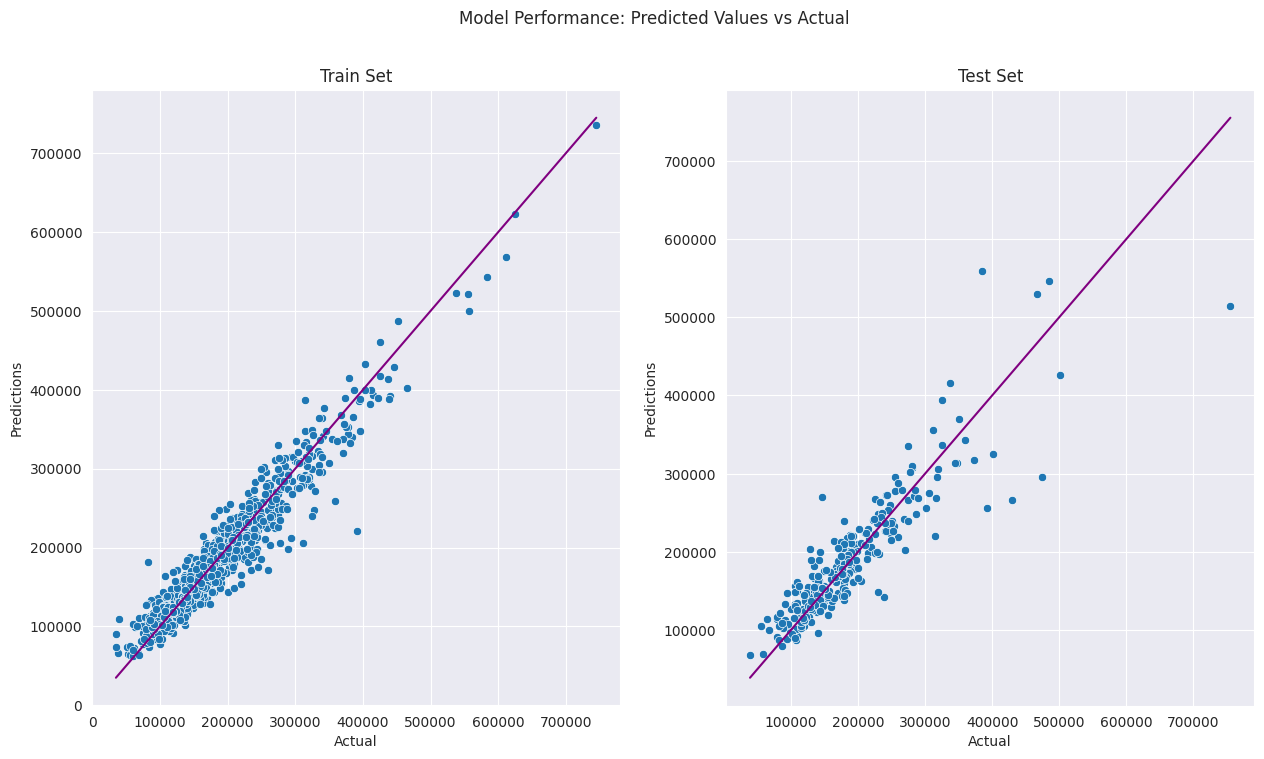

In [40]:
regressor_eval_plot(X_train, y_train, X_test, y_test, optimal_pca_pipeline)

## PCA Conclusions 

* While our model performed well on our Train set using PCA (R<sup>2</sup>=0.925), the model didnt perform as well for the Test set, showing that the model has a slight tendency towards overfitting however this instance is only minor (R<sup>2</sup>=0.811)

---

# Final Conclusions


* Overall while our model using the <code>GradientBoostingRegressor</code> & PCA, did not perform as well as our <code>ExtraTreesRegressor</code> so we will accept that as our final model.
* With more time and resources, several iterations could be led to expand this project to further explore the model performance, including an expanded hyperparameter optimization, and attempting to address the buisness requirement using a classification model rather than regression. 
* Now we can save our files to be used within the dashboard ready for deployment.


---

# Push files to Repo

In [41]:
import os, joblib

version='v1.0.0'
file_path=f'outputs/ml_pipeline/predict_sale_price/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/predict_sale_price/v1.0.0'


### Train & Test Sets

In [42]:
X_train.to_csv(f'{file_path}/X_train.csv', index=False)
X_test.to_csv(f'{file_path}/X_test.csv', index=False)
y_train.to_csv(f'{file_path}/y_train.csv', index=False)
y_test.to_csv(f'{file_path}/y_test.csv', index=False)

### Pipeline

In [43]:
top_performing_pipeline

Pipeline(steps=[('Ordinal Categorical Encoder',
                 OrdinalEncoder(variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('Log "e" Transformer',
                 LogTransformer(variables=['GrLivArea', 'LotArea'])),
                ('Power Transformer',
                 PowerTransformer(variables=['BsmtFinSF1', 'BsmtUnfSF',
                                             'MasVnrArea', 'OpenPorchSF'])),
                ('Box Cox Transformer',
                 BoxCoxTransformer(var...
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     'MasVnrArea',
                                                     'OpenPorchSF',
                                                     'OverallCond',
                                                     'OverallQual',
   

In [45]:
joblib.dump(value=top_performing_pipeline, filename=f'{file_path}/pipeline.pkl')

['outputs/ml_pipeline/predict_sale_price/v1.0.0/pipeline.pkl']